# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Walls and obstacles

We compute minimal paths in domains featuring obstacles, and check that the CPU and GPU codes provide consistent results.

In [1]:
large_instances=True

## 0. Importing the required libraries

In [2]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Flow_Repro','GPU'))

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity

from agd.ExportedCode.Notebooks_GPU.Isotropic_Repro import RunCompare
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen = rreload([HFMUtils,ad,cugen],"../..")
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [6]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

## 1. Isotropic metrics

In [25]:
n=201
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0,0],
    'exportValues':1,
    'cost':1,
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn['tips']=hfmIn.Grid(dims=(4,4)).reshape(2,-1).T

In [26]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [27]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.005980253219604492 seconds, and 11 iterations.
Post-Processing


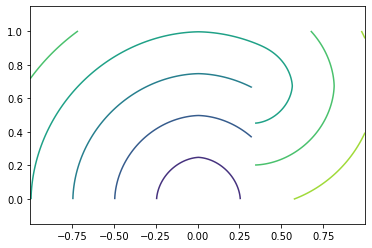

In [28]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'])

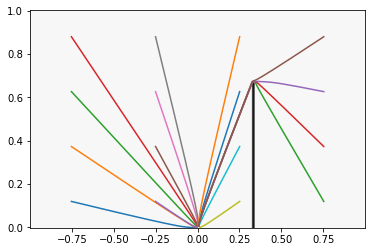

In [31]:
plt.contourf(*X,walls,cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

In [12]:
assert all(stop=='AtSeed' for stop in hfmOut['geodesic_stopping_criteria'])

## 2. Curvature penalized metrics

In [13]:
n = 300 if large_instances else 100 
nTheta = 96 if large_instances else 64
hfmIn = Eikonal.dictIn({
    'model':'Elastica2',
    'seed':[0.,0.,np.pi],
    'exportValues':1,
    'cost':1,
    'xi':0.4,
    'count_updates':True,
#    'bound_active_blocks':True,
})
hfmIn.SetRect([[-1,1],[0,1]],dimx=n+1,sampleBoundary=True)
hfmIn.nTheta = nTheta

tips = hfmIn.Grid(dims=(4,4,4))
tips = np.moveaxis(tips.reshape(3,-1),0,-1)
hfmIn['tips'] = tips

In [14]:
X = hfmIn.Grid()
walls = np.logical_and(X[0]==X[0,int(2*n/3)],X[1]<=2./3.)
hfmIn['walls']=walls

In [15]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 1.3995249271392822 seconds, and 228 iterations.
Post-Processing


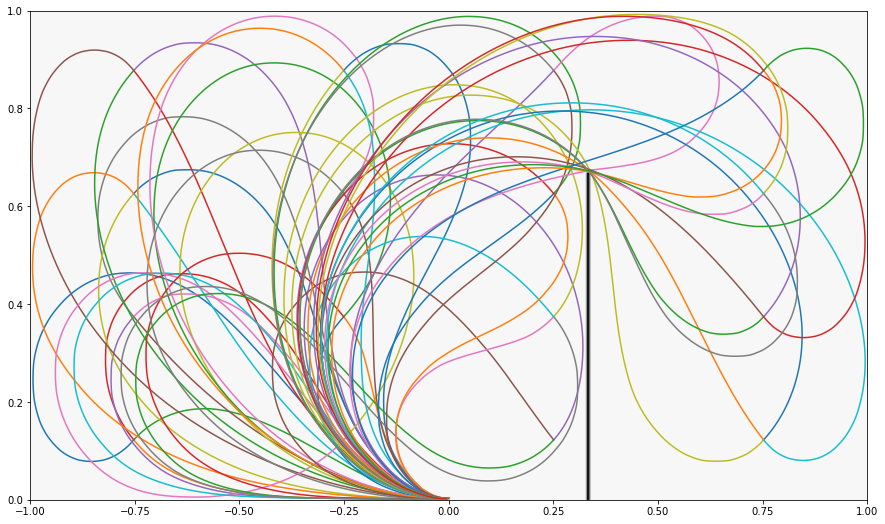

In [22]:
plt.figure(figsize=(15,9)) 
plt.contourf(*X[:2,:,:,0],walls[:,:,0],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(geo[0],geo[1])

All the geodesics end at the seed, except one whose tip is very close to the wall, with an initial orientation headed straight into it. Its stopping criteria is 'InWall'.

In [17]:
assert all(stop in ('AtSeed','InWall') for stop in hfmOut['geodesic_stopping_criteria'])